
# Understanding Dirichlet Processes

Based on the great tutorial by Thomas at [this link](http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/).

A good reference on this material appears to be the workshop presented by Ye Whye Teh at MLSS 2007, 2013. Slides are available [here](http://www.columbia.edu/~jwp2128/Teaching/E6892/papers/mlss2007.pdf) and the recording (multiple parts) is available [here](https://www.youtube.com/watch?v=dNeW5zoNJ7g). An article copy of the tutorial notes are [here](http://www.gatsby.ucl.ac.uk/~ywteh/research/npbayes/dp.pdf).


In [1]:

%matplotlib inline

import math
import random
import operator
import functools

import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib as mpl
import matplotlib.tri as tri
import matplotlib.pyplot as plt



## Urn Construction

Pólya's Urn Scheme is a constructive way to sample form a Dirichlet Process distribution. Also known as the Blackwell-MacQueen urn scheme.

Consider an urn that starts empty, and some base distibution over colors (e.g. assume there are a finite number and the distribution is uniform).

 1. Start by sampling a new color, painting a ball that color, and drop it in the urn.
    
 2. Until we have enough observations (balls in the urn), for each iteration n;

    a. With probability $\frac{\alpha}{\alpha + n}$ sample a new color, paint a new ball that color, and drop it in the urn
    
    b. With probability $\frac{n}{\alpha + n}$, pick a random ball from the urn, and copy it's color onto a new ball. Drop both balls back in the urn.

A simple python implementation follows;


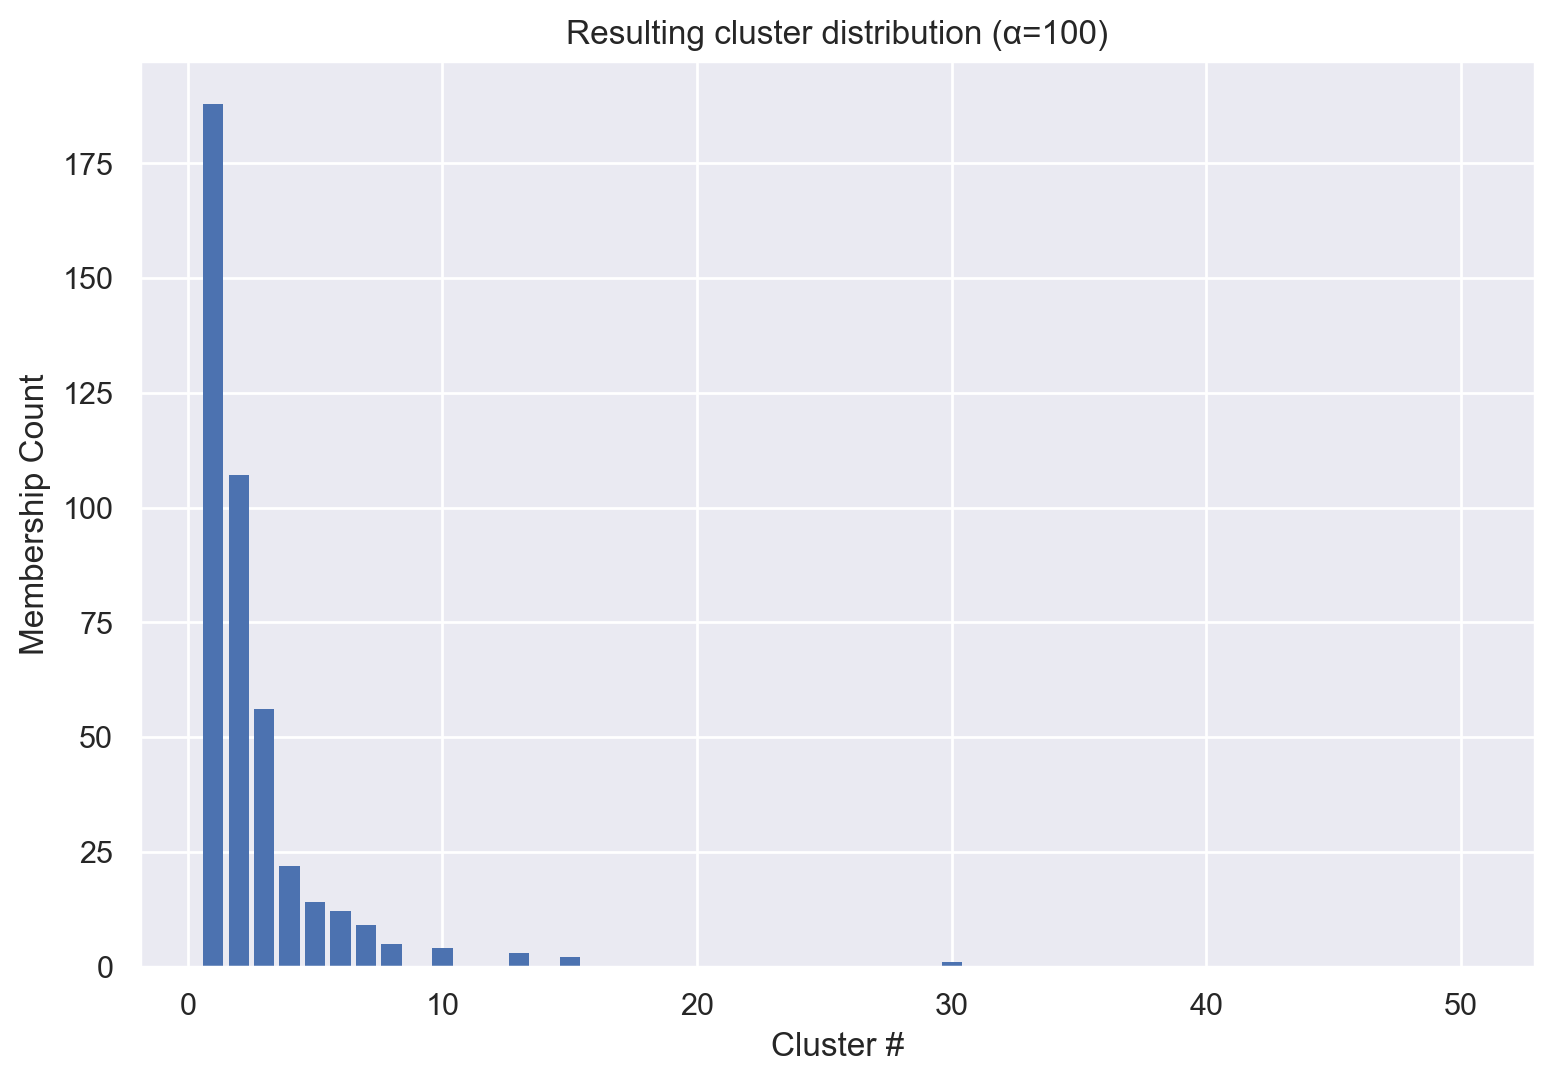

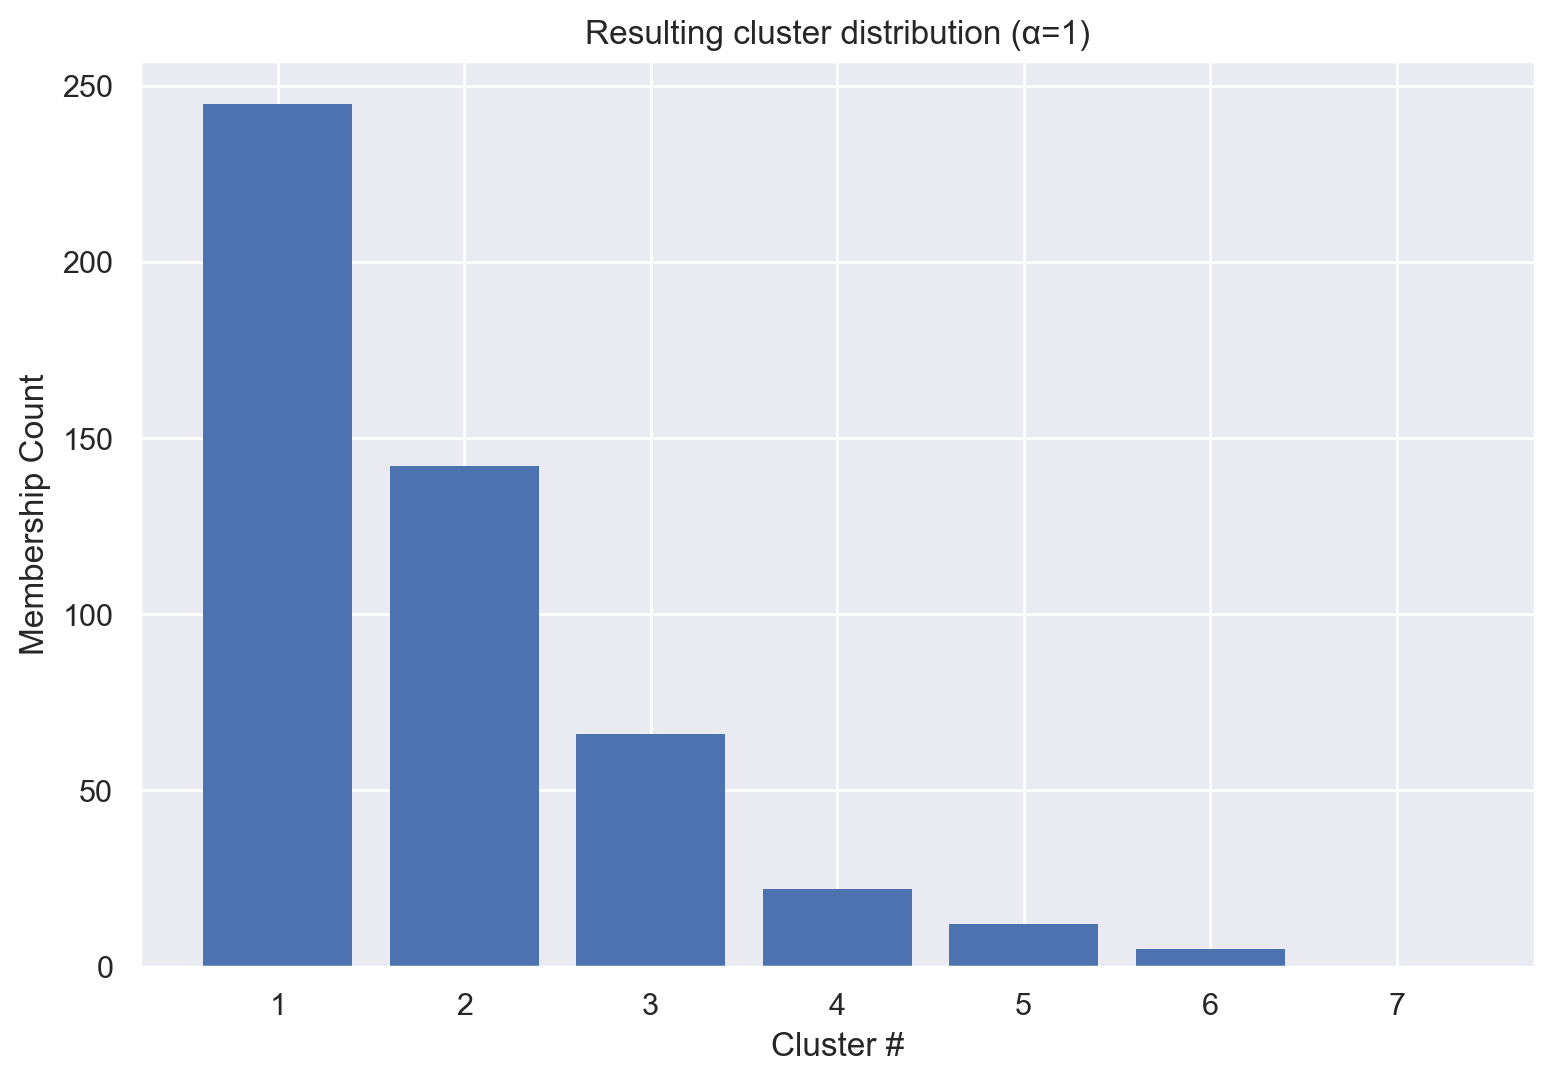

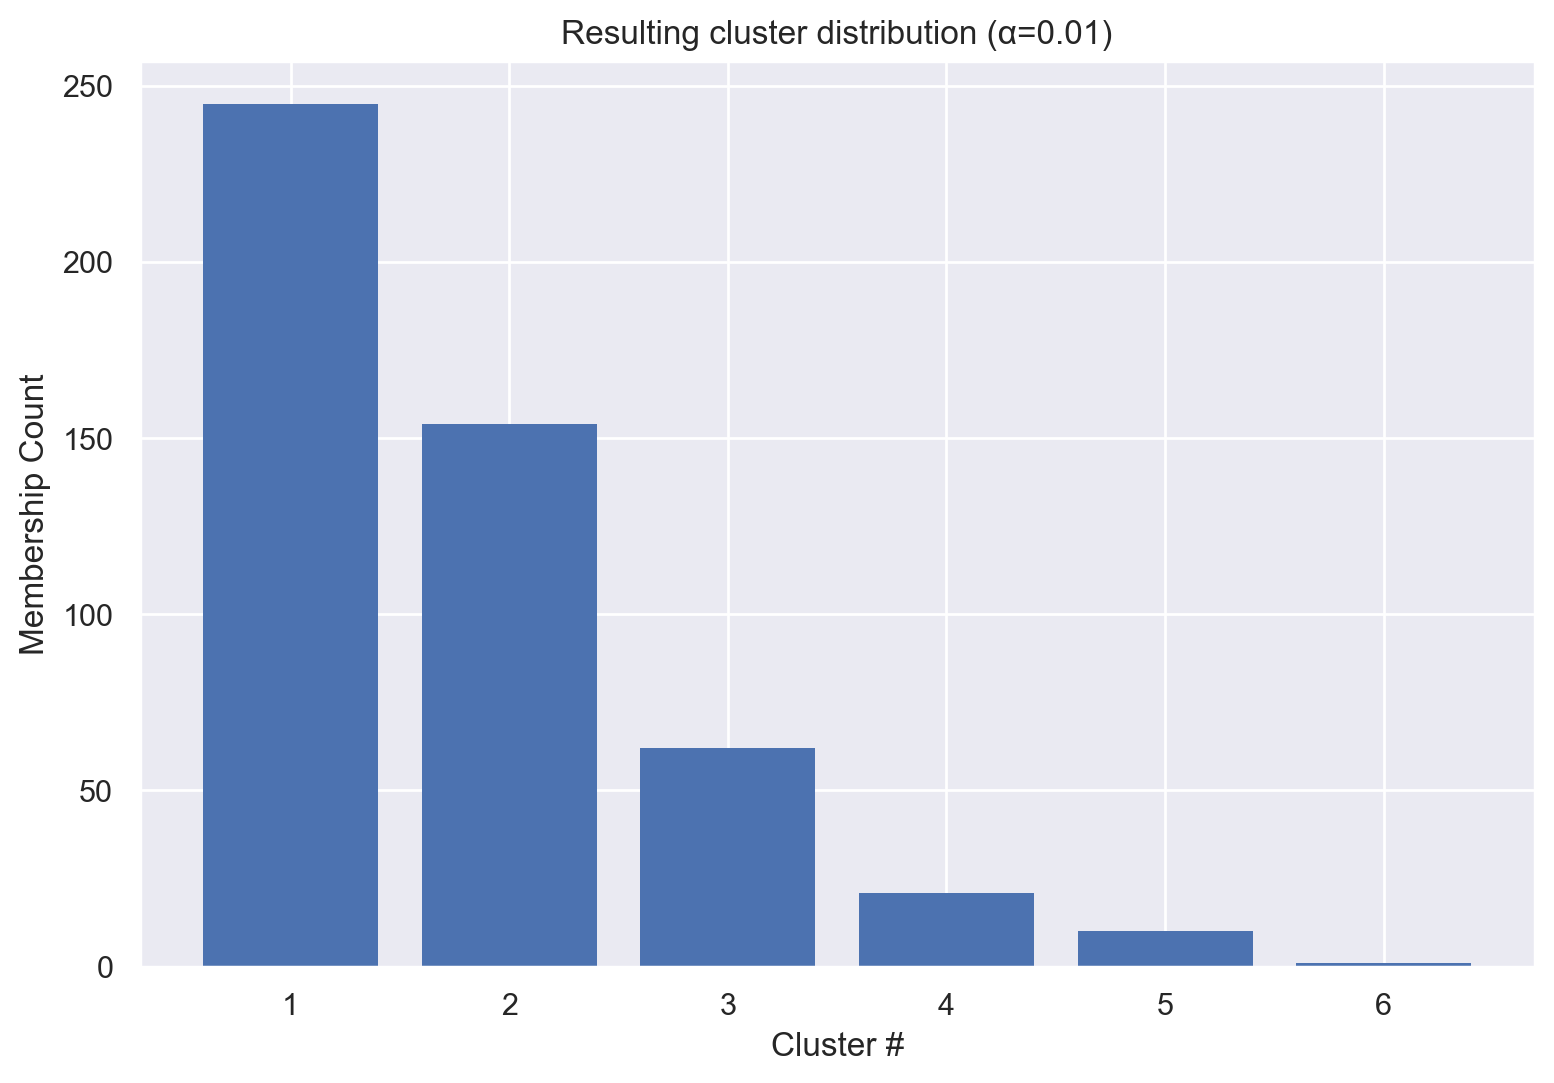

In [2]:

# Bound the space of possible colors
num_colors = 300
new_color = lambda: np.random.randint(0, num_colors)


class Ball():
    
    def __init__(self, color):
        self.color = color
    
    def __repr__(self):
        return f"Ball({self.color})"


def urn_sampling(alpha=10, num_observations=500):
    """The Urn construction scheme follows
    """
    
    # Step 1 - start with a random colored ball in the urn
    urn = [Ball(new_color())]
    
    # Step 2 - Iterate until we have enough observations
    for n in range(1, num_observations - 1):

        p = np.random.rand()
        
        if p > alpha / (alpha + n):
            # Step 2a - sample a new color
            color = new_color()
        else:
            # Step 2b - copy a color from the urn's empirical distribution
            color = random.choice(urn).color
        
        # Create a new ball and add it to the urn
        urn.append(Ball(color))

    # Get the resulting distribution
    colors = [b.color for b in urn]
    
    # Return sorted cluster membership counts, and cluster IDs
    counts = {}
    for c in colors:
        counts[c] = counts.get(c, 0) + 1
    counts = sorted(counts.values())[::-1]
    return counts, list(range(len(counts)))

# Plot cluster size histograms
sns.set()

plt.figure(figsize=(9, 6), dpi=200)
plt.bar(*urn_sampling(100), lw=0)
plt.xlabel("Cluster #")
plt.ylabel("Membership Count")
plt.title("Resulting cluster distribution (α=100)")
plt.show()

plt.figure(figsize=(9, 6), dpi=200)
plt.bar(*urn_sampling(1), lw=0)
plt.xlabel("Cluster #")
plt.ylabel("Membership Count")
plt.title("Resulting cluster distribution (α=1)")
plt.show()

plt.figure(figsize=(9, 6), dpi=200)
plt.bar(*urn_sampling(0.01), lw=0)
plt.xlabel("Cluster #")
plt.ylabel("Membership Count")
plt.title("Resulting cluster distribution (α=0.01)")
plt.show()



## Stick Breaking Construction

The below code demonstrates the stick-breaking construction of the Dirichlet Process



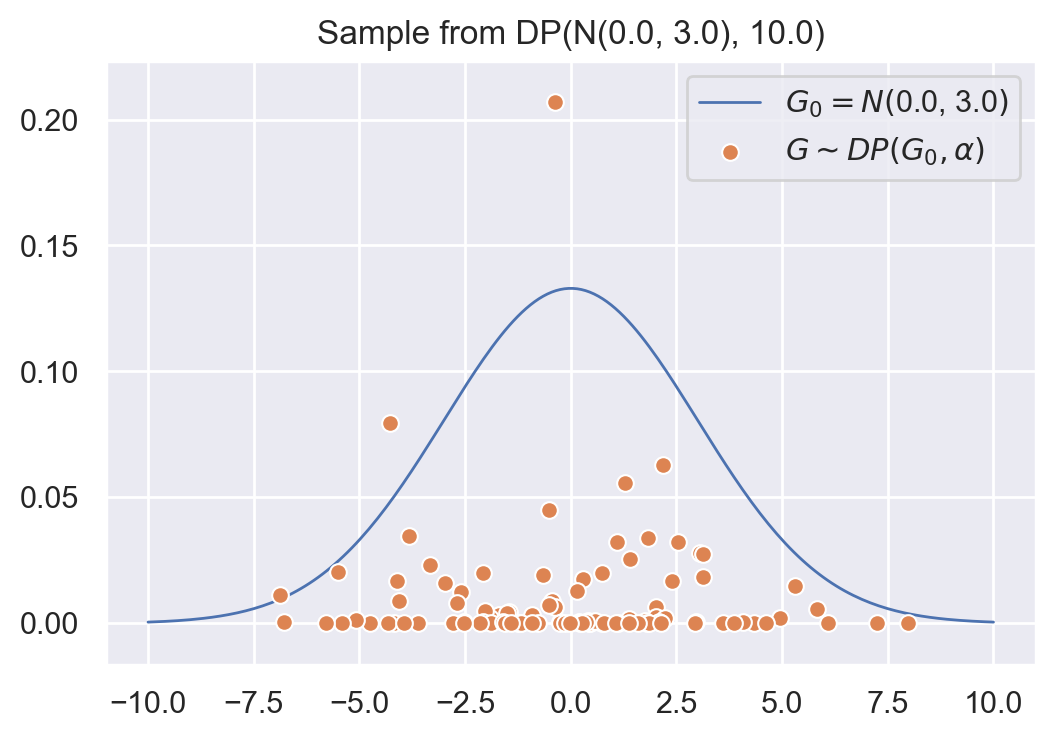

In [3]:

# The base distribution for our GP
G0_mean = 0.0
G0_std = 3.0
G0 = sp.stats.norm(G0_mean, G0_std)

# Concentration parameter for our DP
# Smaller values give more concentrated distributions
alpha = 10.0               # Uniform Beta prior

# Prepare stick-breaking distribution
sbd = sp.stats.beta(1.0, alpha)

n = 100
locs = []
probs = []
beta_primes = []
for k in range(n):
    
    # Sample a location
    locs.append(G0.rvs())
    
    # Snap off some of the stick
    beta_primes.append(sbd.rvs())
    
    # Compute this sample's proportion of the remaining stick
    remaining_stick = np.prod(1.0 - np.array(beta_primes[:-1]))
    probs.append(
        beta_primes[-1] * remaining_stick
    )

# Plot the sampled distribution
sns.set()
plt.figure(figsize=(6, 4), dpi=200)
x = np.linspace(-10, 10, 200)
sns.scatterplot(
    locs,
    probs,
    color='C1',
    label=r'$G \sim DP(G_0, \alpha)$',
    zorder=2
)
plt.plot(
    x,
    G0.pdf(x),
    lw=1,
    label=r'$G_0 = N($' + f'{G0_mean}, {G0_std}' + r'$)$',
    zorder=1
)
plt.legend()
plt.title("Sample from DP(N({}, {}), {})".format(
    G0_mean,
    G0_std,
    alpha
))
plt.show()



## Scikit-learn implementation

Scikit-learn includes an implementation of Dirichlet Prior Gaussian Mixture Model clustering via the [`BayesianGausianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html) class.

The scikit-learn implementation uses variational inference, which is a slightly more sophisticated approach than Gibbs sampling.

Demo code is from [this tutorial page](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html).


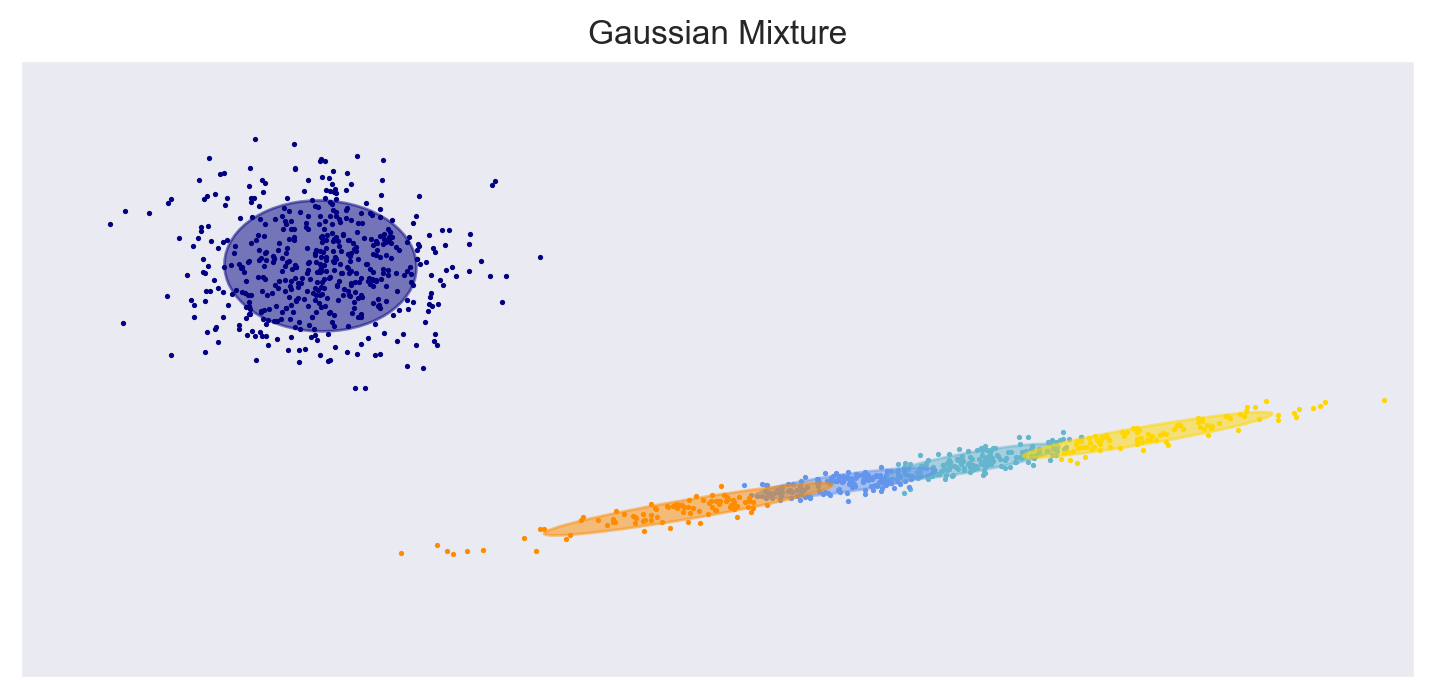

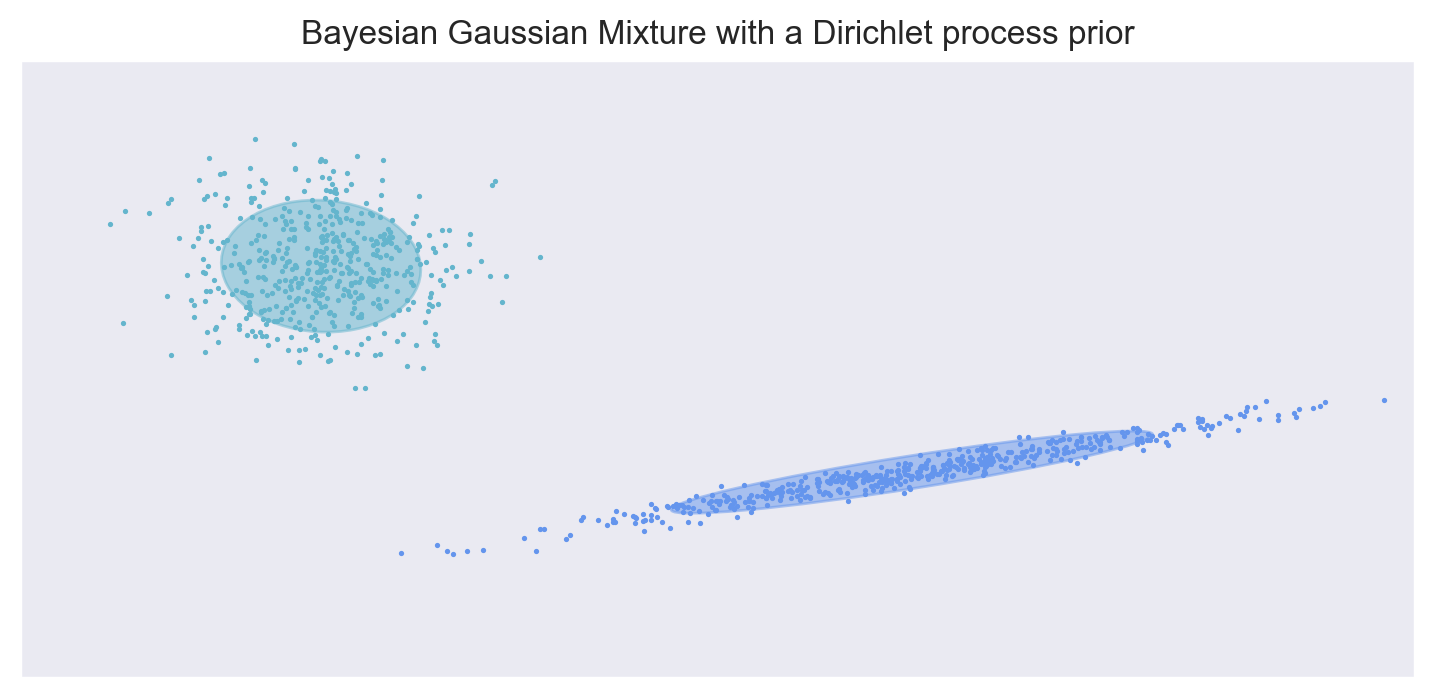

In [4]:
import itertools

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import linalg
from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y_, means, covariances, index, title):
    sns.set()
    plt.figure(figsize=(9, 9), dpi=200)
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)


# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = mixture.BayesianGaussianMixture(
    n_components=5,
    covariance_type='full'
).fit(X)

plot_results(
    X,
    dpgmm.predict(X),
    dpgmm.means_,
    dpgmm.covariances_,
    1,
    'Bayesian Gaussian Mixture with a Dirichlet process prior'
)

plt.show()



## Combining DP priors with deep learning

When it comes to combining non-parametric Bayes DP priors with deep learning, the canonical approach appears to be the 2017 ICLR paper [Stick-breaking variational autoencoders](https://arxiv.org/pdf/1605.06197.pdf) by Nalisnick and Smyth.

He has also given some associated tutorial presentations on the same topic:

 * [Deep generative models with stick-breaking priors](https://www.ics.uci.edu/~enalisni/nalisnick_uciAIML_talk.pdf)
 * [Alternative priors for deep generative models](https://www.ics.uci.edu/~enalisni/nalisnick_uciAIML_talk.pdf)
